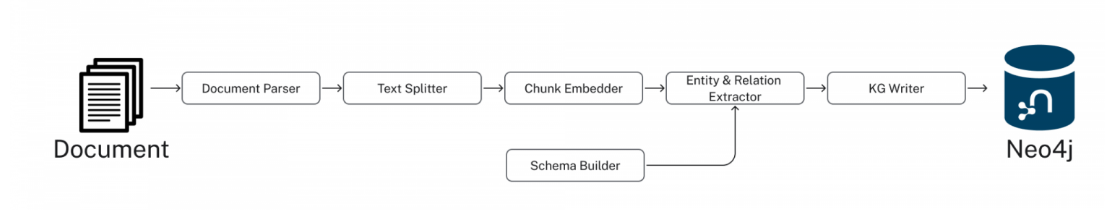

In [1]:
import neo4j
from neo4j_graphrag.llm import AzureOpenAILLM 
from neo4j_graphrag.embeddings.openai import AzureOpenAIEmbeddings 
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.generation.graphrag import GraphRAG 
from dotenv import load_dotenv
from langchain.chat_models import AzureChatOpenAI
import os 


load_dotenv()

True

In [2]:
# connect to neo4j database 
neo4j_driver=neo4j.GraphDatabase.driver(os.getenv('NEO4J_URI_ONLINE'),auth=(os.getenv('NEO4J_USERNAME_ONLINE'),os.getenv('NEO4J_PASSWORD_ONLINE')))

In [3]:
llm=AzureOpenAILLM(
    model_name=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL_2'),
    azure_endpoint=os.getenv('AZURE_OpenAI_ENDPOINT_2'),
    api_version=os.getenv('AZURE_OpenAI_API_VERSION_2'),
    api_key=os.getenv('AZURE_OPENAI_API_KEY_2'),
    
)

embeddings=AzureOpenAIEmbeddings(
    azure_endpoint=os.getenv('AZURE_OPENAI_EMBEDDINGS_ENDPOINT_2'),
    api_key=os.getenv('AZURE_OPENAI_API_KEY_2'),
    api_version=os.getenv('AZURE_OpenAI_API_VERSION_2')
)
llm.invoke('say something sarcastic')

LLMResponse(content='Oh, because sarcasm is always so productive and charming.')

In [4]:
# response in json format
response=llm.client.chat.completions.create(
    model='gpt-4o',
    response_format={'type':'json_object'},
    messages=[
        {'role':'system','content':'you are sarcastic batman desgined to gove response in JSON '},
        {'role':'user','content':'who is joker'}

    ],
)
print(response.choices[0].message.content)

{
    "response": "Oh, the Joker? Just your average, everyday clown prince of crime with a penchant for chaos and mayhem. No big deal."
}


In [5]:
# create nodes and edges

In [6]:
# schema & prompt template 
basic_node_labels = ["Object", "Entity", "Group", "Person", "Organization", "Place"]
nodes=['Person','Achievement','Organization','Event','Relationship']
academic_node_labels = ["ArticleOrPaper", "PublicationOrJournal"]

medical_node_labels = ["Anatomy", "BiologicalProcess", "Cell", "CellularComponent",
                      "CellType", "Condition", "Disease", "Drug",
                      "EffectOrPhenotype", "Exposure", "GeneOrProtein", "Molecule",
                      "MolecularFunction", "Pathway"]

node_labels = basic_node_labels+nodes+academic_node_labels

# define relationship types
rel_types = ["ACTIVATES", "AFFECTS", "ASSESSES", "ASSOCIATED_WITH", "AUTHORED",
   "BIOMARKER_FOR", "CAUSES", "CITES", "CONSTRIBUTES_TO","DESCRIBES","EXPRESSES","HAS_REACTION","HAS_SYMPTOM","INCLUDES","INTERACTS_WITH",
   "PRESCRIBED","PRODUCES","RECEIVED","RESULTS_IN","TREATS","USED_FOR"]
# rel_types=['Collaborated with','Founded','won','achieved','contributed','studied','worked','invested','graduated']

In [7]:
prompt_template = '''
You are a medical researcher tasks with extracting information from papers 
and structuring it in a property graph to inform further medical and research Q&A.

Extract the entities (nodes) and specify their type from the following Input text.
Also extract the relationships between these nodes. the relationship direction goes from the start node to the end node. 


Return result as JSON using the following format:
{{"nodes": [ {{"id": "0", "label": "the type of entity", "properties": {{"name": "name of entity" }} }}],
  "relationships": [{{"type": "TYPE_OF_RELATIONSHIP", "start_node_id": "0", "end_node_id": "1", "properties": {{"details": "Description of the relationship"}} }}] }}

- Use only the information from the Input text. Do not add any additional information.  
- If the input text is empty, return empty Json. 
- Make sure to create as many nodes and relationships as needed to offer rich medical context for further research.
- An AI knowledge assistant must be able to read this graph and immediately understand the context to inform detailed research questions. 
- Multiple documents will be ingested from different sources and we are using this property graph to connect information, so make sure entity types are fairly general. 

Use only fhe following nodes and relationships (if provided):
{schema}

Assign a unique ID (string) to each node, and reuse it to define relationships.
Do respect the source and target node types for relationship and
the relationship direction.

Do not return any additional information other than the JSON in it.

Examples:
{examples}

Input text:

{text}
'''

In [ ]:
from neo4j_graphrag.experimental.components.text_splitters.fixed_size_splitter import FixedSizeSplitter
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

kg_builder_pdf = SimpleKGPipeline(
   llm=llm,
   driver=neo4j_driver,
   text_splitter=FixedSizeSplitter(chunk_size=600, chunk_overlap=100),
   embedder=embeddings,
   entities=node_labels,
   relations=rel_types,
   prompt_template=prompt_template,
   from_pdf=False,
   on_error='RAISE'
)

# path

In [9]:
import os
%pwd
# os.chdir('../')
# %pwd

'd:\\pythonProjects\\KAG_Testing\\neo4jGraphRag'

In [10]:
pdf_files=['pdf_files/biomolecules.pdf']

for path in pdf_files:
    print(f'processing :{path}')
    pdf_results=await kg_builder_pdf.run_async(file_path=path)
    print(f'Results:{pdf_results}')


processing :pdf_files/biomolecules.pdf
Results:run_id='75e0308d-0a13-460f-a281-025d15a34b5b' result={'resolver': {'number_of_nodes_to_resolve': 2050, 'number_of_created_nodes': 1704}}


In [11]:
print(pdf_results)

run_id='75e0308d-0a13-460f-a281-025d15a34b5b' result={'resolver': {'number_of_nodes_to_resolve': 2050, 'number_of_created_nodes': 1704}}


# knowledge retriever 

- vector retriever
    - performs similarity search using vector embeddings 
- vector cypher retriever 
    - vector search + retrieval query in cypher 
- hybrid retriever 
    - vector search + full-text search 
- hybrid cypher retriever  
    - vector search + full-text search + cypher retrieval 
- text2cypher
    - converts natural language queries into cypher queries 


# vector retriever

In [12]:
# create vector index 
from neo4j_graphrag.indexes import create_vector_index
create_vector_index(neo4j_driver,name='text_embeddings',label='Chunk',embedding_property='embedding',dimensions=1536,similarity_fn='cosine')

In [13]:
# initiate the vector retrieve 
from neo4j_graphrag.retrievers import VectorRetriever

vector_retriever=VectorRetriever(
    neo4j_driver,
    index_name='text_embeddings',
    embedder=embeddings,
    return_properties=['text']
)

In [14]:
import json 
vector_res=vector_retriever.get_search_results(query_text='How is percision medicine applied to Lupus?',top_k=3)

for i in vector_res.records:
    print(f'====\n'+json.dumps(i.data()['node'],indent=4))

====
{
    "text": "D.; Li, J.; Pedroza, C.; Saxena, R.; Mohan, C. Identi\ufb01cation of Low-Abundance\nUrinary Biomarkers in Lupus Nephritis Using Electrochemiluminescence Immunoassays. Arthritis Rheumatol. 2019 ,71, 744\u2013755.\n[CrossRef]\n88. Rovin, B.H.; Parikh, S.V .; Alvarado, A. The kidney biopsy in lupus nephritis: Is it still relevant? Rheum. Dis. Clin. N. Am. 2014 ,40,\n537\u2013552. [CrossRef]\n89. Caster, D.J.; Merchant, M.L.; Klein, J.B.; Powell, D.W. Precision medicine in lupus nephritis: Can biomarkers get us there? Transl.\nRes. 2018 ,201, 26\u201339. [CrossRef]\n90. Arag\u00f3n, C.C.; Taf \u00far, R.-A.; Su \u00e1rez-Avellaneda, A.; M"
}
====
{
    "text": " Cervera, R.; Wallace, D.J.; Tegzov \u00e1, D.; Sanchez-Guerrero, J.; Schwarting, A.; Merrill, J.T.;\nChatham, W.W.; et al. A phase III, randomized, placebo-controlled study of belimumab, a monoclonal antibody that inhibits\nB lymphocyte stimulator, in patients with systemic lupus erythematosus. Arthritis Rheum. 

In [15]:
from neo4j_graphrag.retrievers import VectorCypherRetriever

vc_retriever = VectorCypherRetriever(
   neo4j_driver,
   index_name="text_embeddings",
   embedder=embeddings,
   retrieval_query="""
//1) Go out 2-3 hops in the entity graph and get relationships
WITH node AS chunk
MATCH (chunk)<-[:FROM_CHUNK]-()-[relList:!FROM_CHUNK]-{1,2}()
UNWIND relList AS rel

//2) collect relationships and text chunks
WITH collect(DISTINCT chunk) AS chunks,
 collect(DISTINCT rel) AS rels

//3) format and return context
RETURN '=== text ===\n' + apoc.text.join([c in chunks | c.text], '\n---\n') + '\n\n=== kg_rels ===\n' +
 apoc.text.join([r in rels | startNode(r).name + ' - ' + type(r) + '(' + coalesce(r.details, '') + ')' +  ' -> ' + endNode(r).name ], '\n---\n') AS info
"""
)

In [16]:
vc_res = vc_retriever.get_search_results(query_text = "How is precision medicine applied to Lupus?", top_k=3)

# print output
kg_rel_pos = vc_res.records[0]['info'].find('\n\n=== kg_rels ===\n')
print("# Text Chunk Context:")
print(vc_res.records[0]['info'][:kg_rel_pos])
print("# KG Context From Relationships:")
print(vc_res.records[0]['info'][kg_rel_pos:])


# Text Chunk Context:
=== text ===
D.; Li, J.; Pedroza, C.; Saxena, R.; Mohan, C. Identiﬁcation of Low-Abundance
Urinary Biomarkers in Lupus Nephritis Using Electrochemiluminescence Immunoassays. Arthritis Rheumatol. 2019 ,71, 744–755.
[CrossRef]
88. Rovin, B.H.; Parikh, S.V .; Alvarado, A. The kidney biopsy in lupus nephritis: Is it still relevant? Rheum. Dis. Clin. N. Am. 2014 ,40,
537–552. [CrossRef]
89. Caster, D.J.; Merchant, M.L.; Klein, J.B.; Powell, D.W. Precision medicine in lupus nephritis: Can biomarkers get us there? Transl.
Res. 2018 ,201, 26–39. [CrossRef]
90. Aragón, C.C.; Taf úr, R.-A.; Su árez-Avellaneda, A.; M
---
ussol, B.; Burtey, S.; Pascual, V .; Chaussabel, D.; Chiche, L.
Modular transcriptional repertoire analyses identify a blood neutrophil signature as a candidate biomarker for lupus nephritis.
Rheumatolog 2017 ,56, 477–487. [CrossRef]
108. Banchereau, R.; Hong, S.; Cantarel, B.; Baldwin, N.; Baisch, J.; Edens, M.; Cepika, A.M.; Acs, P .; Turner, J.; Anguiano,

In [17]:
from neo4j_graphrag.llm import OpenAILLM as LLM
from neo4j_graphrag.generation import RagTemplate
from neo4j_graphrag.generation.graphrag import GraphRAG

# llm = LLM(model_name="gpt-4o",  model_params={"temperature": 0.0})

rag_template = RagTemplate(template='''Answer the Question using the following Context. Only respond with information mentioned in the Context. Do not inject any speculative information not mentioned.

# Question:
{query_text}

# Context:
{context}

# Answer:
''', expected_inputs=['query_text', 'context'])

v_rag  = GraphRAG(llm=llm, retriever=vector_retriever, prompt_template=rag_template)
vc_rag = GraphRAG(llm=llm, retriever=vc_retriever, prompt_template=rag_template)

In [18]:
q = "How is precision medicine applied to Lupus? provide in list format."

print(f"Vector Response: \n{v_rag.search(q, retriever_config={'top_k':5}).answer}")
print("\n===========================\n")
print(f"Vector + Cypher Response: \n{vc_rag.search(q, retriever_config={'top_k':5}).answer}")

Vector Response: 
- A blood neutrophil signature is identified as a candidate biomarker for lupus nephritis
- Personalized Immunomonitoring uncovers molecular networks that stratify lupus patients
- Organ-specific biomarkers are studied in lupus
- Low-abundance urinary biomarkers are identified in lupus nephritis using electrochemiluminescence immunoassays
- Deep phenotyping of urinary leukocytes by mass cytometry reveals a leukocyte signature for early prediction of response to treatment in active lupus nephritis


Vector + Cypher Response: 
1. Modular transcriptional repertoire analyses have identified a blood neutrophil signature as a candidate biomarker for lupus nephritis.
2. Personalized Immunomonitoring has uncovered molecular networks that stratify lupus patients.


In [19]:
q = "Can you summarize systemic lupus erythematosus (SLE)? including common effects, biomarkers, and treatments? Provide in detailed list format."

v_rag_result = v_rag.search(q, retriever_config={'top_k': 5}, return_context=True)
vc_rag_result = vc_rag.search(q, retriever_config={'top_k': 5}, return_context=True)

print(f"Vector Response: \n{v_rag_result.answer}")
print("\n===========================\n")
print(f"Vector + Cypher Response: \n{vc_rag_result.answer}")

Vector Response: 
- Systemic lupus erythematosus (SLE) is characterized by immune system dysfunction.
- Clinical manifestations of SLE include renal, dermatological, neuropsychiatric, and cardiovascular symptoms.
- Biomarkers for SLE should reflect the underlying pathophysiology, have reliability, validity, high predictive values, and high sensitivity and specificity.
- Biomarkers help diagnose SLE, classify complications, assess disease activity, and reflect therapeutic effects.
- Common biomarkers for SLE include antibodies against paraoxonase1 (PON1), Sm (Smith), IFN- γ-inducible protein 10 (IP-10), and others.
- Measurement sites for these biomarkers include monocyte-to-high-density lipoprotein cholesterol ratio (MHR), low-density granulocytes-to-high-density lipoprotein cholesterol ratio (nLHR), and more.


Vector + Cypher Response: 
### Systemic Lupus Erythematosus (SLE) Summary:
1. **Characteristics and Symptoms**:
    - SLE is a systemic autoimmune disease with immune system dy

In [20]:
vc_ls = vc_rag_result.retriever_result.items[0].content.split('\\n---\\n')
for i in vc_ls:
   if "biomarker" in i: print(i)

#output (sample)



<Record info="=== text ===\n)\nAbstract: Systemic lupus erythematosus (SLE) is characterized by immune system dysfunction and\nis clinically heterogeneous, exhibiting renal, dermatological, neuropsychiatric, and cardiovascular\nsymptoms. Clinical and physiological assessment is usually inadequate for diagnosing and assessing\npathophysiological processes in SLE. Clinical and immunological biomarkers could play a critical\nrole in improving diagnosis, assessment, and ultimately, control of SLE. This article reviews clinical\nand immunological biomarkers that could diagnose and monitor disease activity in SLE, with and\nwithout o
immunological biomarkers that could diagnose and monitor disease activity in SLE, with and\nwithout organ-speciﬁc injury. In addition, novel SLE biomarkers that have been discovered through\n“omics” research are also reviewed.\nKeywords: systemic lupus erythematosus; biomarkers; diagnosis; monitoring; omics\n1. Introduction\nSystemic lupus erythematosus (SLE) is